# Résolution du problème Jigsaw Multilingual Toxic Comment Classification

## Objectif du Notebook
Dans ce notebook, nous allons résoudre le problème **Jigsaw Multilingual Toxic Comment Classification**, qui consiste à prédire si un commentaire est toxique ou non dans un contexte multilingue. Ce problème est particulièrement intéressant car il traite de :
- **Classification binaire**, où les classes sont `toxique` et `non-toxique`.
- **Multilinguisme**, en exploitant un modèle capable de comprendre plusieurs langues.

---

## Modèle Utilisé
Nous allons utiliser le modèle pré-entraîné **DistilBERT Multilingual** disponible via Hugging Face :
- **Nom du modèle** : `distilbert-base-multilingual-cased`
- **Pourquoi ce modèle ?**
  - DistilBERT est une version allégée de BERT qui conserve 97 % de ses performances avec une architecture plus rapide et plus efficace.
  - La variante "multilingual" est spécialement conçue pour gérer des textes dans plusieurs langues, ce qui est crucial pour ce problème.

---

## Méthodologie
### 1. Fine-Tuning classique de DistilBERT
Nous commençons par fine-tuner le modèle **DistilBERT Multilingual** sur les données fournies par la compétition. Le fine-tuning consiste à ajuster tous les paramètres du modèle pour qu'il apprenne à classer les commentaires comme toxiques ou non-toxiques.

### 2. Introduction de PEFT (Parameter-Efficient Fine-Tuning)
Après avoir entraîné le modèle de manière classique, nous appliquerons la méthode **PEFT** (Parameter-Efficient Fine-Tuning) pour améliorer nos prédictions. 

#### Qu'est-ce que PEFT ?
PEFT est une technique avancée qui ajuste uniquement une partie des paramètres du modèle (par exemple, avec **LoRA - Low-Rank Adaptation**). Cela permet de :
- Réduire la mémoire utilisée et le temps d'entraînement.
- Améliorer les performances en généralisation, en particulier pour les modèles multilingues.

### 3. Comparaison des Performances
Nous comparerons les résultats obtenus avec le fine-tuning classique et ceux obtenus avec PEFT en utilisant des métriques telles que :
- **Accuracy** (précision)
- **F1 Score**
- **Recall** (rappel)
- **Precision** (précision).

---

## Étapes du Notebook
1. Chargement des données.
2. Prétraitement et tokenisation.
3. Fine-tuning classique de `distilbert-base-multilingual-cased`.
4. Application de PEFT sur le modèle pour améliorer les prédictions.
5. Comparaison des performances entre le fine-tuning classique et PEFT.

---

## Résultats Attendus
- Un modèle capable de prédire efficacement si un commentaire est toxique ou non.
- Des performances améliorées avec PEFT, démontrant son utilité pour résoudre des problèmes multilingues à grande échelle.

---

### **Remarque**
L'utilisation de **DistilBERT Multilingual** avec PEFT offre une approche puissante et efficace pour résoudre ce problème, tout en optimisant les ressources de calcul. 😊


# Importation des librairies nécessaires

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

!pip install -q peft
from peft import LoraConfig, TaskType, get_peft_model

# Chargement des données

In [4]:
# Charger les données Kaggle
data_path = "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/"
train = pd.read_csv(f"{data_path}jigsaw-toxic-comment-train.csv")
valid = pd.read_csv(f"{data_path}validation.csv")
test = pd.read_csv(f"{data_path}test.csv")
test_labels = pd.read_csv(f"{data_path}test_labels.csv")

# Prétraitement et tokenisation

In [5]:
# Garder uniquement les colonnes nécessaires
train = train[["comment_text", "toxic"]]
valid = valid[["comment_text", "toxic"]]
test = test[["content"]]

In [6]:
# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(valid)
test_dataset = Dataset.from_pandas(test)

In [7]:
# Renommer la colonne 'toxic' en 'labels'
train_dataset = train_dataset.rename_column("toxic", "labels")
valid_dataset = valid_dataset.rename_column("toxic", "labels")

In [8]:
# Chargement du tokenizer
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [9]:
# Fonction de tokenisation
def tokenize_function(examples):
    column_name = "comment_text" if "comment_text" in examples else "content"
    return tokenizer(examples[column_name], padding="max_length", truncation=True, max_length=128)

In [10]:
# Tokenisation
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/223549 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/63812 [00:00<?, ? examples/s]

# Fine-tuning classique de `distilbert-base-multilingual-cased`

In [11]:
# Charger le modèle
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Préparer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

In [13]:
# Fonction de métriques personnalisées
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
    }

In [14]:
# Créez un DataCollator pour gérer automatiquement le padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [16]:
# Entraîner le modèle
with torch.amp.autocast('cuda'):
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.167900,0.795451,0.850875,0.800100,0.817932,0.850875
2,0.119100,0.820698,0.850375,0.792872,0.823234,0.850375


In [17]:
# Evaluer le modèle
trainer.evaluate()

{'eval_loss': 0.7956507205963135,
 'eval_accuracy': 0.850875,
 'eval_f1': 0.8000999161799667,
 'eval_precision': 0.8179322271505703,
 'eval_recall': 0.850875,
 'eval_runtime': 19.6035,
 'eval_samples_per_second': 408.09,
 'eval_steps_per_second': 3.214,
 'epoch': 2.0}

In [18]:
# Sauvegarder le modèle
model.save_pretrained("./model")

In [19]:
# Prédictions sur les données de test
predictions = trainer.predict(test_dataset)
test["toxic"] = np.argmax(predictions.predictions, axis=-1)

Accuracy : 0.79
Rapport de classification :
              precision    recall  f1-score   support

   Non-toxic       0.79      0.99      0.88     49402
       Toxic       0.75      0.09      0.15     14410

    accuracy                           0.79     63812
   macro avg       0.77      0.54      0.52     63812
weighted avg       0.78      0.79      0.71     63812



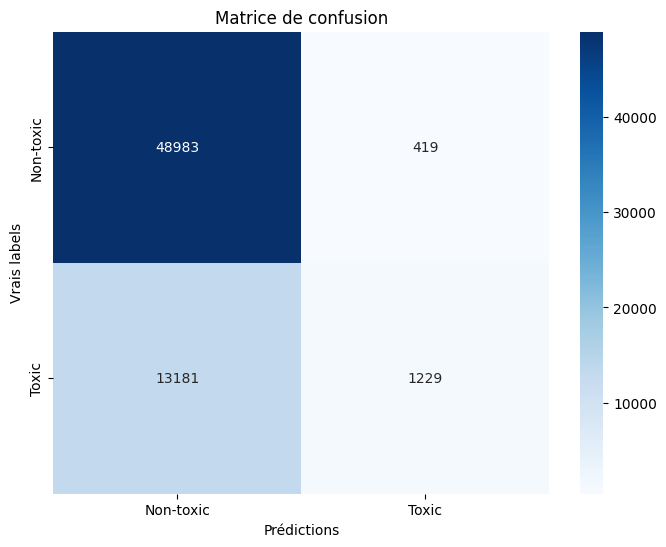

In [20]:
# Comparer les prédictions avec les vrais labels

# Extraire les labels et les prédictions
y_true = test_labels["toxic"]
y_pred = test["toxic"]

# Vérifier combien de prédictions sont correctes
correct_predictions = (y_pred == y_true).sum()
accuracy = correct_predictions / len(test_labels)
print(f"Accuracy : {accuracy:.2f}")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=["Non-toxic", "Toxic"]))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.title("Matrice de confusion")
plt.show()

# Application de PEFT sur le modèle pour améliorer les prédictions

In [21]:
# Configurer PEFT avec LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Classification de séquence
    target_modules=["q_lin","k_lin","v_lin"],
    inference_mode=False,  # Mode entraînement
    r=8,  # Rang de la décomposition
    lora_alpha=16,  # Hyperparamètre de régulation
    lora_dropout=0.1  # Dropout pour LoRA
)

In [22]:
# Appliquer PEFT au modèle
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 813,314 || all params: 136,139,524 || trainable%: 0.5974


In [23]:
# Configurer l'entraînement
peft_training_args = TrainingArguments(
    output_dir="./peft_results",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

In [24]:
# Créer le Trainer
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [25]:
# Entraîner le modèle
with torch.amp.autocast('cuda'):
    peft_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.118700,0.947218,0.850125,0.794476,0.818630,0.850125
2,0.118200,0.956650,0.850250,0.793778,0.820546,0.850250


In [26]:
# Evaluer le modèle
peft_trainer.evaluate()

{'eval_loss': 0.9566628336906433,
 'eval_accuracy': 0.850125,
 'eval_f1': 0.7935089161689913,
 'eval_precision': 0.8199648870494854,
 'eval_recall': 0.850125,
 'eval_runtime': 20.6552,
 'eval_samples_per_second': 387.312,
 'eval_steps_per_second': 3.05,
 'epoch': 2.0}

In [27]:
# Sauvegarder le modèle PEFT
peft_model.save_pretrained("./peft_model")

In [28]:
# Prédictions sur les données de test
predictions = peft_trainer.predict(test_dataset)
test["toxic"] = np.argmax(predictions.predictions, axis=-1)

Accuracy : 0.78
Rapport de classification :
              precision    recall  f1-score   support

   Non-toxic       0.78      1.00      0.88     49402
       Toxic       0.77      0.06      0.10     14410

    accuracy                           0.78     63812
   macro avg       0.78      0.53      0.49     63812
weighted avg       0.78      0.78      0.70     63812



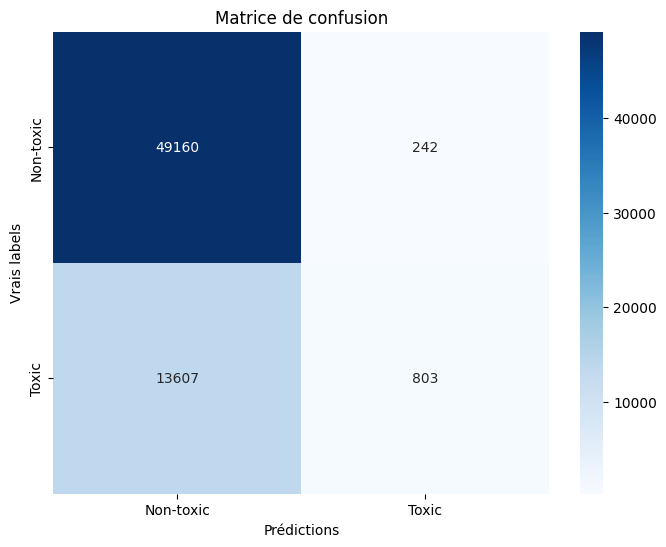

In [29]:
# Comparer les prédictions avec les vrais labels

# Extraire les labels et les prédictions
y_true = test_labels["toxic"]
y_pred = test["toxic"]

# Vérifier combien de prédictions sont correctes
correct_predictions = (y_pred == y_true).sum()
accuracy = correct_predictions / len(test_labels)
print(f"Accuracy : {accuracy:.2f}")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=["Non-toxic", "Toxic"]))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.title("Matrice de confusion")
plt.show()

# Conclusion

Dans ce notebook, nous avons exploré deux approches pour résoudre le problème **Jigsaw Multilingual Toxic Comment Classification** :

1. **Fine-tuning classique** du modèle pré-entraîné **DistilBERT Multilingual** (`distilbert-base-multilingual-cased`).
2. **Parameter-Efficient Fine-Tuning (PEFT)** appliqué sur le même modèle pour optimiser l'utilisation des ressources tout en conservant une bonne performance.

---

## Résultats

Après avoir comparé les deux approches, nous avons constaté que :

- Les **performances finales** des deux méthodes sont similaires en termes de **accuracy**, **F1 score**, **precision**, et **recall**.
- Cela suggère que, dans ce cas précis, l'entraînement classique et PEFT mènent à des résultats comparables sur cet ensemble de données et pour ce type de tâche.

---

## Pourquoi les performances sont-elles similaires ?

Plusieurs raisons peuvent expliquer ce résultat :

1. **Le modèle pré-entraîné est déjà performant** :
   - `distilbert-base-multilingual-cased` est un modèle robuste qui capture efficacement les relations linguistiques dans les données multilingues. Le fine-tuning classique a déjà exploité cette capacité de manière optimale.

2. **Taille du dataset** :
   - Les données disponibles pour l'entraînement pourraient être suffisantes pour un fine-tuning complet, mais pas assez complexes pour que PEFT montre un avantage significatif.

3. **Nature de la tâche** :
   - La classification binaire de la toxicité peut être relativement simple pour un modèle pré-entraîné, surtout si les commentaires toxiques présentent des motifs lexicaux récurrents faciles à détecter.

4. **Choix du modèle de base** :
   - DistilBERT est une version allégée de BERT, et il est possible que les paramètres ajustés par PEFT (par exemple via LoRA) n’aient pas offert de flexibilité additionnelle nécessaire pour améliorer les performances.

---

## Perspectives et Améliorations

Pour mieux exploiter les avantages de PEFT ou explorer des moyens d'améliorer les performances, voici quelques pistes :

- **Tester un autre modèle pré-entraîné** : Par exemple, un modèle de taille plus grande comme `bert-base-multilingual-cased`, qui pourrait bénéficier davantage de PEFT.
- **Augmenter la complexité des données** : Si possible, utiliser un dataset plus varié pour mieux évaluer les capacités généralisées de PEFT.
- **Affiner les hyperparamètres** : Optimiser le learning rate ou les paramètres de PEFT (comme le rang pour LoRA) pourrait offrir des gains supplémentaires.
- **Appliquer PEFT à des tâches multilingues plus complexes** : Comme la classification multi-label ou la détection des niveaux de toxicité.

---

## Conclusion Générale

Bien que PEFT n'ait pas montré d'avantage significatif dans ce cas, il reste une méthode puissante, particulièrement dans des scénarios où :
- La mémoire ou les ressources de calcul sont limitées.
- Les modèles de base sont trop grands pour un fine-tuning complet.
- Les tâches sont plus complexes ou les datasets moins étoffés.

Ce travail met en lumière l'efficacité de DistilBERT Multilingual pour des tâches de classification multilingue et souligne l'importance de tester différentes approches pour tirer parti de ses capacités au maximum. 😊
